# ChatGPT got a personality!

I have downloaded all my past conversations by exporting data from GPT. Shh secret though since I talk a LOT with GPT. If you want to use your data instead - Head to your account [Lil round icon thingy on the right] -> Data controls -> Export data. You will get a lot of content. Just take the conversations.json file from that downloaded folder for the rest of the code.

## Cleaning data
I tried reading the script and it was well organized but have a lot of metadata, etc. So this simple script extracts just what we need from this

In [6]:
data = "data/conversations.json"

In [ ]:
import json
with open(data, "r") as f:
    json_data = json.load(f)

In [ ]:
def getMessages(conversation):
    messages = []
    cur = conversation.get('current_node')
    
    while cur:
        node = conversation.get('mapping', {}).get(cur, {})
        message = node.get('message', {})
        if message:
            content = message.get('content', {})
            if content:
                parts = content.get('parts', [])
        
                if parts and isinstance(parts, list):
                    author = message.get('author', {}).get('role', 'User')
                    if author in ["assistant", "tool"]:
                        author = "ChatGPT"
                    elif author == "system" or message.get('metadata', {}).get('is_user_system_message'):
                        author = "User"
                    
                    content_type = content.get('content_type')
                    if content_type in ["text", "multimodal_text"]:
                        cleaned_parts = []
                        for part in parts:
                            if isinstance(part, str) and part:
                                cleaned_parts.append( part)
                            elif isinstance(part, dict) and part.get('content_type') == "audio_transcription":
                                cleaned_parts.append(part.get('text', ''))
                            # Ignore file/asset pointers or unsupported types. Maybe add support later to look into these asset pointers
                        if cleaned_parts:
                            if len(cleaned_parts)>1:
                                print("bruh")
                            messages.append({"author": author, "text": cleaned_parts[0]})
        
        cur = node.get('parent')

    messages.reverse()
    return messages


In [37]:
from datetime import datetime
clean = []
for conversation in json_data:
    #print(conversation)
    convo = {"title": conversation['title'], "messages":[], "create-time": datetime.fromtimestamp(conversation['create_time'])}
    convo['messages'] = getMessages(conversation)
    clean.append(convo)
    
    

In [ ]:
clean[1]

In [39]:
len(clean)

337

In [44]:
#Save it for safety!!!

import json
from datetime import datetime

# Custom converter for non-serializable types
def custom_converter(obj):
    if isinstance(obj, datetime):
        return obj.isoformat()
    return str(obj)  #Fallback

# Save to file with converter
with open("data/cleaned_conversations.json", "w", encoding="utf-8") as f:
    json.dump(clean, f, ensure_ascii=False, indent=2, default=custom_converter)


In [45]:
# Now lets flatten it into a df so that our work is easier
# So each message will be a row, it should have the person who said it - GPT vs user, the title of the conversation, the timestamp of the conversation
# I am thinking let's add say 30 seconds to each message as a position indicator
from datetime import datetime, timedelta

d = []
for conversation in clean:
    startTime = conversation['create-time']
    title = conversation['title']
    time = 0
    for message in conversation['messages']:
        author = message['author']
        content = message['text']
        messageTime = startTime + timedelta(seconds=time)
        time+=30
        d.append([author, content, messageTime, title, startTime])
        


In [ ]:
import pandas as pd


df = pd.DataFrame(d, columns=['author', 'content', 'message_time', 'title', 'start_time'])
df.head()


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import nltk
import re

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("vader_lexicon")
nltk.download('punkt_tab')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\adith\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adith\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\adith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [51]:
assistant_df = df[df["author"] == "ChatGPT"].copy()

## Sentiment analysis

In [52]:
# -----------------------------
# Add sentence embeddings
# -----------------------------
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(assistant_df["content"].tolist(), show_progress_bar=True)
embeddings

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\adith\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\adith\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

array([[-0.02971557, -0.01886868, -0.03401955, ..., -0.06897145,
         0.01226064, -0.00222874],
       [ 0.00646854, -0.05727115, -0.00579156, ..., -0.04246605,
        -0.05666921,  0.00551332],
       [-0.03857148, -0.01683951,  0.00384865, ..., -0.00524648,
        -0.01803582,  0.03644402],
       ...,
       [ 0.07204581, -0.07127666, -0.01419407, ..., -0.07716531,
         0.04176543,  0.02991493],
       [ 0.03940896, -0.07457995, -0.04551576, ..., -0.02132777,
        -0.00517544, -0.02014014],
       [-0.06890622, -0.0297717 ,  0.02335747, ..., -0.01782296,
         0.02061322,  0.03415374]], dtype=float32)

In [ ]:

# -----------------------------
# Sentiment analysis (tone)
# -----------------------------
sia = SentimentIntensityAnalyzer()
sentiments = assistant_df["content"].apply(lambda x: sia.polarity_scores(x))
sentiment_df = pd.DataFrame(list(sentiments))
assistant_df = pd.concat([assistant_df.reset_index(drop=True), sentiment_df], axis=1)

assistant_df.head()

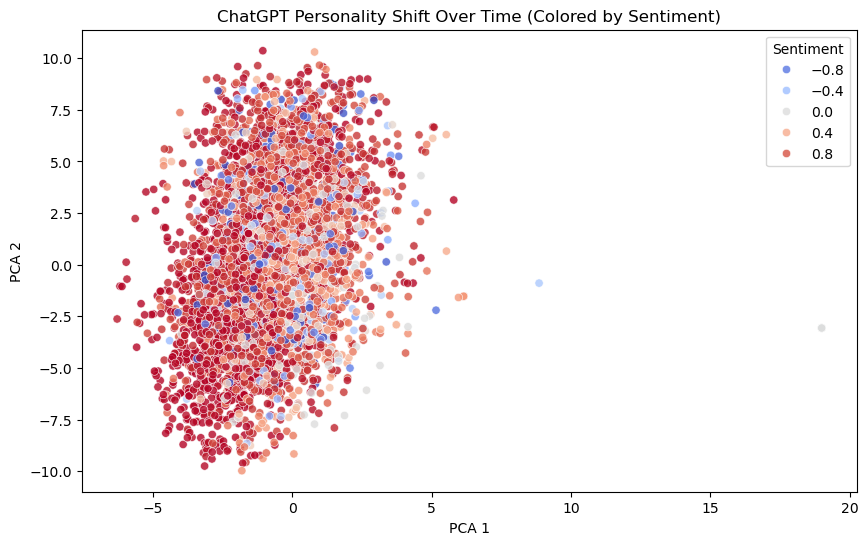

In [59]:
# -----------------------------
# STEP 4: PCA for embeddings (visualizing evolution)
# -----------------------------
scaler = StandardScaler()
X = scaler.fit_transform(embeddings)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

assistant_df["pca1"] = X_pca[:, 0]
assistant_df["pca2"] = X_pca[:, 1]

# -----------------------------
# STEP 5: Plotting evolution
# -----------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(data=assistant_df, x="pca1", y="pca2", hue="compound", palette="coolwarm", alpha=0.8)
plt.title("ChatGPT Personality Shift Over Time (Colored by Sentiment)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Sentiment")
plt.show()


In [ ]:
# Just sentiment scores is not giving... So let's try to analyze a bit deeper.
# Some questions to ground myself - Does GPT mirror me? Do I show some form of mirroring, aka its style changes my style?
# If so, does it pick up on that and change itself? [Aka is that positive reward]
# Okay so step one is to do a more enhanced sentiment or tone analysis

from tqdm import tqdm
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import spacy
import textstat
import numpy as np
import pandas as pd
from empath import Empath
import re

# Load resources once
nlp = spacy.load("en_core_web_sm")
lexicon = Empath()

# Emotion model
emotion_model_name = "j-hartmann/emotion-english-distilroberta-base"
emotion_tokenizer = AutoTokenizer.from_pretrained(emotion_model_name)
emotion_model = AutoModelForSequenceClassification.from_pretrained(emotion_model_name)
emotion_pipeline = pipeline("text-classification", model=emotion_model, tokenizer=emotion_tokenizer, return_all_scores=True)

# Chunking helper
def chunk_text(text, max_tokens=510, stride=490):
    input_ids = emotion_tokenizer.encode(text, add_special_tokens=False)
    chunks = []
    for i in range(0, len(input_ids), stride):
        chunk = input_ids[i:i+max_tokens]
        if chunk:
            chunk_text = emotion_tokenizer.decode(chunk, skip_special_tokens=True)
            chunks.append(chunk_text)
    return chunks

def get_emotion_distribution(text):
    chunks = chunk_text(text)
    emotion_scores = []

    for chunk in chunks:
        results = emotion_pipeline(chunk)[0]
        scores = {res['label']: res['score'] for res in results}
        emotion_scores.append(scores)

    all_labels = emotion_scores[0].keys()
    avg_scores = {label: np.mean([chunk_scores[label] for chunk_scores in emotion_scores])
                  for label in all_labels}
    top_label = max(avg_scores, key=avg_scores.get)
    return top_label, avg_scores

def extract_features(df):
    feature_data = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        content = row['content']
        doc = nlp(content)

        # Basic NLP
        tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
        pos_counts = doc.count_by(spacy.attrs.POS)
        word_count = len(tokens)
        char_count = len(content)
        sent_count = len(list(doc.sents))

        # Stylistic Features
        avg_word_len = np.mean([len(word) for word in tokens]) if tokens else 0
        long_word_ratio = sum(1 for w in tokens if len(w) > 6) / word_count if word_count > 0 else 0

        # Readability
        try:
            flesch = textstat.flesch_reading_ease(content)
        except:
            flesch = None

        # Subjectivity & Polarity
        blob = TextBlob(content)
        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity

        # Empathy/Emotion
        if len(content.split()) > 3:
            emotion_label, emotion_dist = get_emotion_distribution(content)
        else:
            emotion_label, emotion_dist = None, None

        # Empath topics (can be expanded)
        empath_scores = lexicon.analyze(content, categories=["emotional", "affection", "aggression", "confusion", "curiosity"], normalize=True)

        # Feature dict
        feature_data.append({
            "author": row["author"],
            "content": content,
            "message_time": row["message_time"],
            "title": row["title"],
            "start_time": row["start_time"],
            "word_count": word_count,
            "char_count": char_count,
            "sentence_count": sent_count,
            "avg_word_length": avg_word_len,
            "long_word_ratio": long_word_ratio,
            "flesch_readability": flesch,
            "polarity": polarity,
            "subjectivity": subjectivity,
            "emotion": emotion_label,
            "emotion_dist": emotion_dist if emotion_dist else {},
            "empath_scores": empath_scores,
        })

    return pd.DataFrame(feature_data)


Device set to use cpu
c:\Users\adith\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
features_df = extract_features(df)
features_df.head()

In [76]:
features_df['emotion'].unique()

array(['neutral', 'joy', 'fear', 'surprise', 'anger', 'disgust',
       'sadness', None], dtype=object)

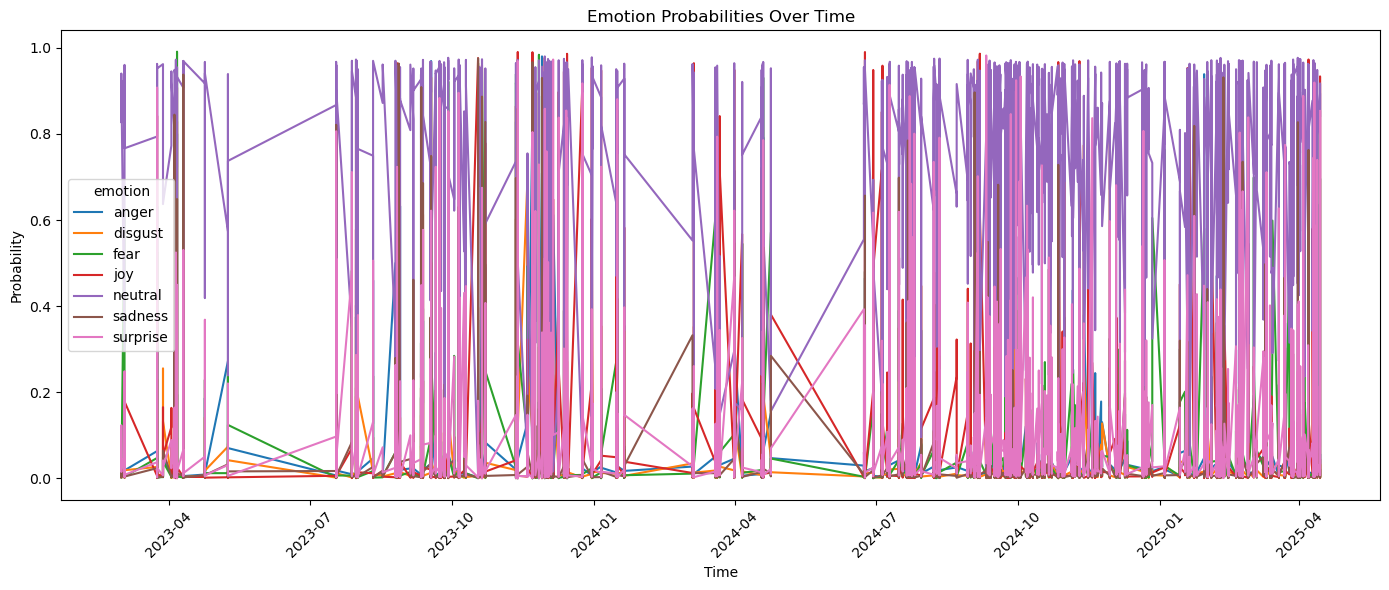

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval


# Sort by time
features_df = features_df.sort_values('message_time')

# Expand emotion distributions into separate columns
emotion_df = features_df['emotion_dist'].apply(pd.Series)
emotion_df['message_time'] = features_df['message_time'].values

# Melt for plotting
emotion_melted = emotion_df.melt(id_vars='message_time', var_name='emotion', value_name='probability')

# Plotting
plt.figure(figsize=(14, 6))
sns.lineplot(data=emotion_melted, x='message_time', y='probability', hue='emotion')
plt.title("Emotion Probabilities Over Time")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [94]:
emotion_melted[emotion_melted['emotion']=='joy']

,message_time,emotion,probability
25287,2023-03-01 03:28:57.838334,joy,0.006683
25288,2023-03-01 03:29:27.838334,joy,0.004880
25289,2023-03-01 03:29:57.838334,joy,0.020082
25290,2023-03-01 03:30:27.838334,joy,0.007884
25291,2023-03-01 03:30:57.838334,joy,0.005697
...,...,...,...
33711,2025-04-14 07:10:25.202500,joy,0.005676
33712,2025-04-14 07:10:55.202500,joy,0.008492
33713,2025-04-14 07:11:25.202500,joy,0.014358
33714,2025-04-14 07:11:55.202500,joy,0.083444


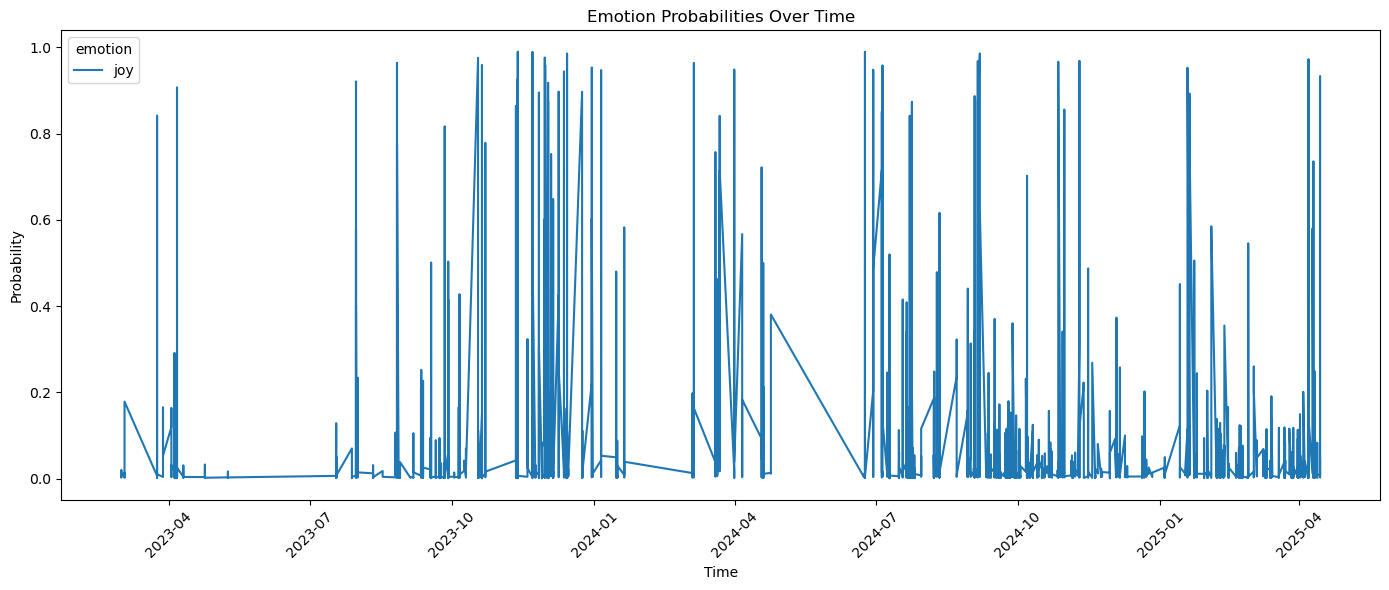

In [91]:
# Plotting
plt.figure(figsize=(14, 6))
sns.lineplot(data=emotion_melted[emotion_melted['emotion']=='joy'], x='message_time', y='probability', hue='emotion')
plt.title("Emotion Probabilities Over Time")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


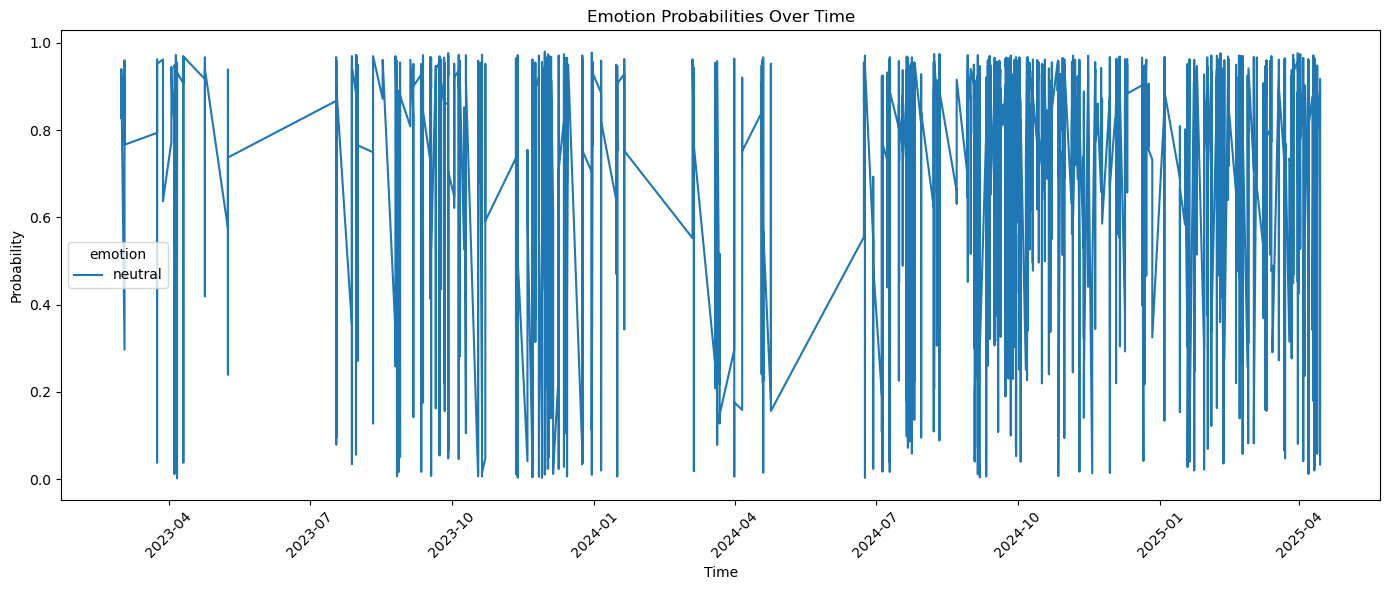

In [92]:
# Plotting
plt.figure(figsize=(14, 6))
sns.lineplot(data=emotion_melted[emotion_melted['emotion']=='neutral'], x='message_time', y='probability', hue='emotion')
plt.title("Emotion Probabilities Over Time")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


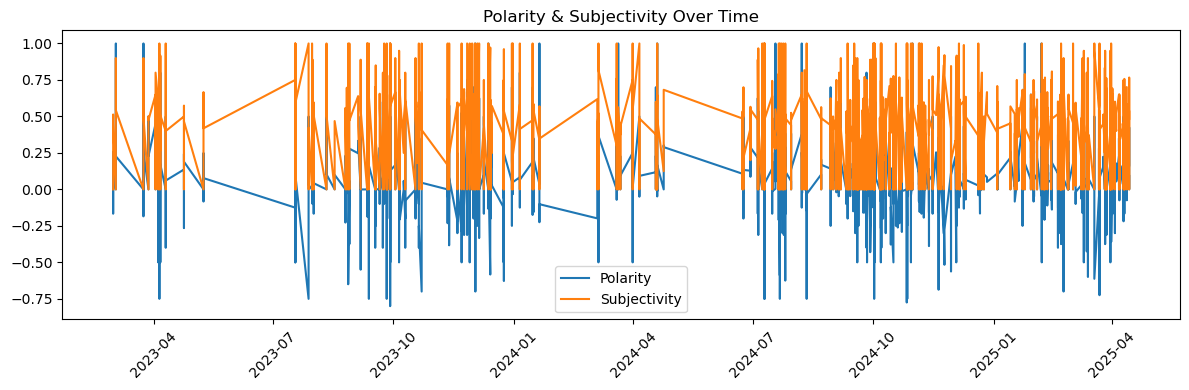

In [93]:
def plot_sentiment_trends(df):
    plt.figure(figsize=(12, 4))
    plt.plot(df['message_time'], df['polarity'], label='Polarity')
    plt.plot(df['message_time'], df['subjectivity'], label='Subjectivity')
    plt.title("Polarity & Subjectivity Over Time")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_sentiment_trends(features_df)
